<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/Duolingo_q1lfulldataset_splitting_modeling_logreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Approach: 
Split Xq1 and yq1 into 80-20 train validation split.
save them as separate. 

looking at
1. log reg
2. decision tree
3. skipping svm and knn.
4. random forest
5. adaboost
6. xgboost
7. neural net dense in keras

compare best performances for each type of model. 

Getting yq1 and Xq1:

Getting yq1 from datadfq1

In [1]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
datadfq1 = decompress_pickle(path_name+"Unseen_words_training_set.pbz2") 

In [5]:
datadfq1.head()

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,student_word,student_lang
7,1.0,1362082032,444407,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,3,3,1,1,"(u:dDwF, 73eecb492ca758ddab5371cf7b5cca32)","(u:dDwF, en)"
15,1.0,1362082130,77,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,5,5,1,1,"(u:dDwF, 73eecb492ca758ddab5371cf7b5cca32)","(u:dDwF, en)"
20,1.0,1362082274,1634777,u:dDwF,es,en,c84476c460737d9fb905dca3d35ec995,niños/niño<n><m><pl>,9,8,2,2,"(u:dDwF, c84476c460737d9fb905dca3d35ec995)","(u:dDwF, en)"
21,1.0,1362082274,1708699,u:dDwF,es,en,1a913f2ded424985b9c02d0436008511,leo/leer<vblex><pri><p1><sg>,7,5,2,2,"(u:dDwF, 1a913f2ded424985b9c02d0436008511)","(u:dDwF, en)"
22,1.0,1362082274,1708699,u:dDwF,es,en,38b770e66595fea718366523b4f7db3f,libro/libro<n><m><sg>,8,8,4,4,"(u:dDwF, 38b770e66595fea718366523b4f7db3f)","(u:dDwF, en)"


In [6]:
datadfq1.shape, datadfq1.size/10**6

((7313354, 14), 102.386956)

In [7]:
datadfq1['p_forgot_bin'] = np.where(1 - datadfq1['p_recall'] >0,1,0).astype(int)

In [32]:
yq1 = datadfq1['p_forgot_bin']

In [9]:
compressed_pickle(path_name+"yq1all",yq1)

Getting saved yq1 from drive:

Gatting Xq1 from drive

In [2]:
Xq1 = decompress_pickle(path_name+"Xq1all.pbz2") 
yq1 = decompress_pickle(path_name+"yq1all.pbz2") 

In [3]:
type(Xq1), type(yq1)

(scipy.sparse.coo.coo_matrix, pandas.core.series.Series)

In [4]:
from scipy.sparse import coo_matrix

In [5]:
Xq1.shape, yq1.shape

((7313354, 2233), (7313354,))

splitting into 80-20 training and validation set with a random state = 5. (had to remove stratify argument, because it doesn't work for sparse arrays)

In [6]:
from sklearn.model_selection import train_test_split

Xq1_train, Xq1_valid, yq1_train, yq1_valid = train_test_split(Xq1,yq1,test_size=0.2,random_state=5)

In [7]:
Xq1_train.shape, Xq1_valid.shape, yq1_train.shape, yq1_valid.shape

((5850683, 2233), (1462671, 2233), (5850683,), (1462671,))

Fraction of ones in the train and validation sets

In [8]:
yq1_train.sum()/yq1_train.shape[0], yq1_valid.sum()/yq1_valid.shape[0]

(0.1611603294863181, 0.16108748994134703)

They are about the same, we will use this split to test a number of models. They are saved below:

First, we scale and transform the data using the min-max scaler. 

In [9]:
from sklearn.preprocessing import MaxAbsScaler # used because sparse array not supported by MinMaxScaler
mm_scaler = MaxAbsScaler()

mm_scaler.fit(Xq1_train)
Xq1_mm_train = mm_scaler.transform(Xq1_train)
Xq1_mm_valid = mm_scaler.transform(Xq1_valid)


### Logistic regression

Hyperparamters:
1. C
2. class weights
3. penalty - starting with l1 to see which features are important, and then l2 for fitting. 


In [10]:
from sklearn.model_selection import ShuffleSplit
#cv = KFold(n_splits=5, test_size=0.3, random_state=0)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

from sklearn.model_selection import cross_validate

from sklearn.metrics import make_scorer # to define a list of scoring metrics to use

from sklearn.model_selection import GridSearchCV

# iterate over 
logreg = LogisticRegression(max_iter = 100,solver='liblinear',verbose=10,penalty='l1')
logreg.fit(Xq1_mm_train,yq1_train)
yq1_train_preds = logreg.predict(Xq1_mm_train)

#scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

#cv_results = cross_validate(logreg,Xq1_mm_train,yq1_train,cv=cv,scoring=scoring_metrics,verbose=10,return_estimator = True)

#sorted(cv_results.keys())

[LibLinear]

In [12]:
from sklearn.metrics import accuracy_score, PrecisionRecallDisplay, roc_auc_score

In [13]:
accuracy_score(yq1_train,yq1_train_preds)

0.8397665708430965

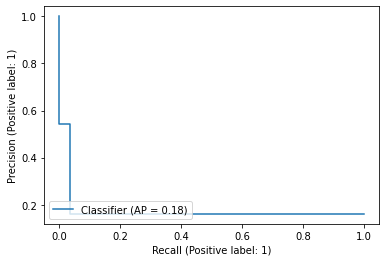

In [14]:
PrecisionRecallDisplay.from_predictions(yq1_train,yq1_train_preds)

In [15]:
roc_auc_score(yq1_train,yq1_train_preds)

0.5153751675544869

In [30]:
column_names = decompress_pickle(path_name+"q1_1_columnnames.pbz2")

In [33]:
coefficients = logreg.coef_.reshape(2233,)

In [34]:
coefficients = pd.Series(logreg.coef_.reshape(2233,),index=column_names)

In [35]:
coefficients.head(10)

delta                1.228215
history_seen       131.564006
history_correct   -148.787487
session_seen         6.654343
LL_es               -1.050063
LL_fr               -0.910518
LL_it               -1.144337
LL_pt               -1.160102
UIL_es              -1.157980
UIL_pt              -1.179814
dtype: float64

In [36]:
coefficients.abs().sort_values(ascending=False).head(20)

history_correct    148.787487
history_seen       131.564006
session_seen         6.654343
nfor                 3.087332
ext                  2.808001
nado                 2.359969
etu                  2.272635
xt                   2.114067
xa                   2.030466
ende                 2.005279
dade                 2.003677
éri                  1.992205
eff                  1.973663
iga                  1.853825
ef                   1.839187
siti                 1.830802
ecti                 1.825933
imie                 1.741529
cé                   1.732884
ctor                 1.729729
dtype: float64

Positive coefficients:

In [41]:
coefficients.sort_values(ascending=False).head(20)

history_seen        131.564006
session_seen          6.654343
nfor                  3.087332
xt                    2.114067
dade                  2.003677
éri                   1.992205
eff                   1.973663
ecti                  1.825933
imie                  1.741529
cé                    1.732884
ctor                  1.729729
lef                   1.724543
spa                   1.626593
ore                   1.610337
oute                  1.609101
mod_@prn:ce_dont      1.582707
lect                  1.551519
tel                   1.550547
ref                   1.508821
itu                   1.493109
dtype: float64

Negative coefficients

In [43]:
coefficients.sort_values().head(20)

history_correct   -148.787487
ext                 -2.808001
nado                -2.359969
etu                 -2.272635
xa                  -2.030466
ende                -2.005279
iga                 -1.853825
ef                  -1.839187
siti                -1.830802
sec                 -1.711384
nfo                 -1.681989
cl                  -1.649686
ontr                -1.635850
titu                -1.593241
reu                 -1.561752
once                -1.553242
nada                -1.539405
erra                -1.522568
tten                -1.431785
esc                 -1.405241
dtype: float64

In [45]:
coefficients.to_csv(path_name+"Logreg_L1_q1fulldataset_coefficients.csv")

Makes sense that lower history correct gives a greater chance of forgetting the word. 

Of the 2223 features, 2037 had non-zero coefficients. 

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train_unscaled)
X_mm_train = mm_scaler.transform(X_train_unscaled)
X_mm_test = mm_scaler.transform(X_test_unscaled)
XGB_model = XGBClassifier(num_feature = 5,subsample = 0.5)
XGB_model.fit(X_mm_train, y_train)
print(f"XG Boost train set score: {XGB_model.score(X_mm_train, y_train)}")
print(f"XG Boost test set score: {XGB_model.score(X_mm_test, y_test)}")

XG Boost train set score: 0.8408690367669401
XG Boost test set score: 0.8364779874213837


In [ ]:
y_train.value_counts(normalize=True)

0    0.838074
1    0.161926
Name: p_forgot_bin, dtype: float64

In [ ]:
y_probaXGB = XGB_model.predict_proba(X_mm_test)[:,1]

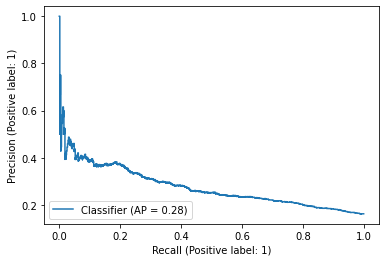

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_test,y_probaXGB)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
AB_model = AdaBoostClassifier(n_estimators=150, learning_rate=1)

AB_model.fit(X_train_unscaled,y_train)
y_probaAB = AB_model.predict_proba(X_test_unscaled)[:,1]

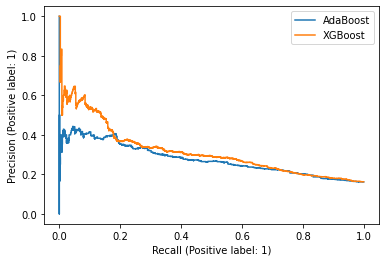

In [ ]:
from sklearn.metrics import accuracy_score, PrecisionRecallDisplay
plt.figure()
ax = plt.gca()
PrecisionRecallDisplay.from_predictions(y_test,y_probaAB,ax=ax,label="AdaBoost")
PrecisionRecallDisplay.from_predictions(y_test,y_probaXGB,ax=ax,label="XGBoost")
plt.legend()
plt.show()

In [ ]:
pd.Series(dict(zip(X_test_unscaled.columns,AB_model.feature_importances_))).sort_values(ascending=False).head(10)

delta           0.046667
session_seen    0.046667
history_frac    0.040000
history_seen    0.020000
dos             0.013333
fa              0.006667
form            0.006667
ff              0.006667
fes             0.006667
fami            0.006667
dtype: float64

Take a subset of 20,000, and use all features. expect around baseline accuracy. 

In [ ]:
q1lexemes['sf_length']

0         4
1         5
2         3
3         5
4         1
         ..
12155     5
12156    10
12157     5
12158     3
12159     9
Name: sf_length, Length: 12160, dtype: int64

In [ ]:
dataffq1 = pd.merge(left = datadfq1, right = q1lexemes[['lexeme_id','sf_length']],how="left",left_on='lexeme_id',right_on='lexeme_id')

In [ ]:
dataffq1['p_forgot_bin'] = np.where(1 - dataffq1['p_recall']>0,1,0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


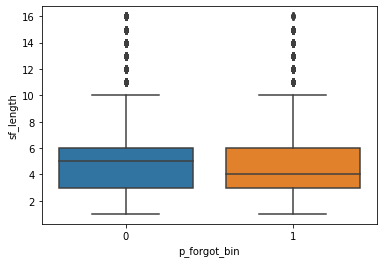

In [ ]:
sns.boxplot(dataffq1['p_forgot_bin'],dataffq1['sf_length'])